# ML Modeling and Evaluation Notebook

### Objectives:

Fit and evaluate a regression model

### Inputs:

outputs/datasets/cleaned/cleanedDataset.csv

### Outputs:

### Price Optimization Based on Course Popularity

Business Case:
By analyzing the relationship between the price, number of subscribers, and number of reviews, you can develop a dynamic pricing strategy. For example, courses with more subscribers or positive reviews can be priced higher. Similarly, courses with fewer subscribers could have discounts or special promotions to attract more learners. This pricing strategy could boost revenue by aligning course prices with demand and perceived value.

- Perform regression analysis to understand how price correlates with factors like subscribers and reviews.
- Segment courses by popularity (e.g., top 10%, bottom 10%) and analyze the pricing strategies for each group.
- Implement dynamic pricing algorithms based on market demand and course popularity.

### 1. Import libraries and get the current directory path

In [7]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# In case you want to go one directory back
current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))

### 2. Check the data

In [8]:
df = pd.read_csv(f"outputs/datasets/cleaned/cleanedDataset.csv")

In [9]:
df.head()

,course_id,course_title,url,is_paid,price,num_subscribers,num_reviews,num_lectures,level,content_duration,published_timestamp,subject
0,1070968,Ultimate Investment Banking Course,https://www.udemy.com/ultimate-investment-bank...,1,200,2147,23,51,All Levels,1.5,2017-01-18 20:58:58+00:00,Business Finance
1,1113822,Complete GST Course & Certification - Grow You...,https://www.udemy.com/goods-and-services-tax/,1,75,2792,923,274,All Levels,39.0,2017-03-09 16:34:20+00:00,Business Finance
2,1006314,Financial Modeling for Business Analysts and C...,https://www.udemy.com/financial-modeling-for-b...,1,45,2174,74,51,Intermediate Level,2.5,2016-12-19 19:26:30+00:00,Business Finance
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,https://www.udemy.com/complete-excel-finance-c...,1,95,2451,11,36,All Levels,3.0,2017-05-30 20:07:24+00:00,Business Finance
4,1011058,How To Maximize Your Profits Trading Options,https://www.udemy.com/how-to-maximize-your-pro...,1,200,1276,45,26,Intermediate Level,2.0,2016-12-13 14:57:18+00:00,Business Finance


In [10]:
print('Unique Subjects',df['subject'].unique())
print('Unique Levels',df['level'].unique())

Unique Subjects ['Business Finance' 'Graphic Design' 'Musical Instruments'
 'Web Development']
Unique Levels ['All Levels' 'Intermediate Level' 'Beginner Level' 'Expert Level']


### 3. Data Cleaning

In [11]:
def clean_data(df):
    # Drop irrelevant rows when is_paid is not 1
    df = df[df['is_paid'] == 1]
    
    # Drop irrelevant columns
    df = df.drop(['course_title', 'course_id', 'url', 'published_timestamp', 'is_paid'], axis=1)
    
    # Handle missing values for numeric columns
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

    # Handle missing values for categorical columns (if any)
    categorical_columns = df.select_dtypes(include=[object]).columns
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0])  # Assign the filled values directly

    return df

# Applying the clean_data function
df = clean_data(df)

In [12]:
df.head(3)

,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject
0,200,2147,23,51,All Levels,1.5,Business Finance
1,75,2792,923,274,All Levels,39.0,Business Finance
2,45,2174,74,51,Intermediate Level,2.5,Business Finance


In [13]:
df.shape

(3362, 7)

### 4. Feature Engineering

In [14]:
# Feature Engineering
def feature_engineering(df):
    # Encode categorical variables (level and subject)
    le_level = LabelEncoder()
    df['level'] = le_level.fit_transform(df['level'])

    le_subject = LabelEncoder()
    df['subject'] = le_subject.fit_transform(df['subject'])
    
    # Feature Engineering
    df['review_subscriber_ratio'] = df['num_reviews'] / df['num_subscribers']
    df['course_popularity'] = df['num_subscribers'] * df['num_reviews']
    df['lectures_to_duration'] = df['num_lectures'] / df['content_duration']  # Added new feature for course structure
    
    return df, le_level, le_subject
df, le_level, le_subject = feature_engineering(df)

In [15]:
df.head(3)

,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject,review_subscriber_ratio,course_popularity,lectures_to_duration
0,200,2147,23,51,0,1.5,0,0.010713,49381,34.000000
1,75,2792,923,274,0,39.0,0,0.330587,2577016,7.025641
2,45,2174,74,51,3,2.5,0,0.034039,160876,20.400000


### 5. Scaling Features

In [16]:
# Scaling the numerical features
def scale_features(df):
    scaler = StandardScaler()
    features = ['num_subscribers', 'num_reviews', 'num_lectures', 'content_duration', 
                'review_subscriber_ratio', 'course_popularity', 'lectures_to_duration', 'price']
    df[features] = scaler.fit_transform(df[features])
    return df, scaler

df, scaler = scale_features(df)

In [17]:
df.head(3)

,price,num_subscribers,num_reviews,num_lectures,level,content_duration,subject,review_subscriber_ratio,course_popularity,lectures_to_duration
0,2.121877,-0.043361,-0.117098,0.175466,0,-0.443224,0,-0.583750,-0.054602,2.644169
1,0.046520,0.058611,0.854073,4.459695,0,5.553675,0,2.459540,-0.024592,-0.669134
2,-0.451566,-0.039093,-0.062065,0.175466,3,-0.283307,0,-0.361826,-0.053278,0.973659


### 6. Train Test split

In [19]:
# Define features (X) and target (y)
X = df.drop('price', axis=1)
y = df['price']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 7. Train Model without Tuning

In [20]:
# Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

#### Define the model and train it

In [21]:
def train_model(X_train, y_train):
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(X_train, y_train)
    return rf_model

In [22]:
rf_model = train_model(X_train, y_train)
mae, mse, r2 = evaluate_model(rf_model, X_test, y_test)
print("Model Evaluation without Tuning:")
print(f"MAE: {mae}, MSE: {mse}, R2 Score: {r2}")

Model Evaluation without Tuning:
MAE: 0.7024317875908909, MSE: 0.8446812746076038, R2 Score: 0.1251877815625866


These results indicate that the model's predictive accuracy is limited, with low explanatory power as reflected by the R² score. Further tuning and optimization are required to improve performance.

### 8. Hyperparameter Tuning

In [23]:
# Hyperparameter Tuning using GridSearchCV
def tune_model(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf_model = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Return the best model and the best parameters
    return grid_search.best_estimator_, grid_search.best_params_

tuned_rf_model, best_params = tune_model(X_train, y_train)
print(f"Best Parameters: {best_params}")

Fitting 3 folds for each of 81 candidates, totalling 243 fits


/Users/panda/Desktop/code_institue_projects/portfolio-projects/learning_trends_analyzer/.venv/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}


The optimal hyperparameters identified are:

- max_depth: 10
- min_samples_leaf: 4
- min_samples_split: 10
- n_estimators: 200
  
These parameters were selected to improve model performance by balancing complexity and overfitting.

### 9. Evaluate Tuned Model

In [26]:
mae_tuned, mse_tuned, r2_tuned = evaluate_model(tuned_rf_model, X_test, y_test)
print("\nModel Evaluation with Tuning:")
print(f"MAE: {mae_tuned}, MSE: {mse_tuned}, R2 Score: {r2_tuned}")


Model Evaluation with Tuning:
MAE: 0.6826617562451318, MSE: 0.7932718642215237, R2 Score: 0.17843103638589086
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   3.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.2s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.3s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   2.1s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.2s
[CV] END max_depth=10, min_samples_leaf=4, min_samples_split=5, n_estimators=1

These results show a slight improvement in accuracy and explanatory power compared to the untuned model, indicating that tuning has enhanced the model's performance.

### 10. Plot Feature Importance

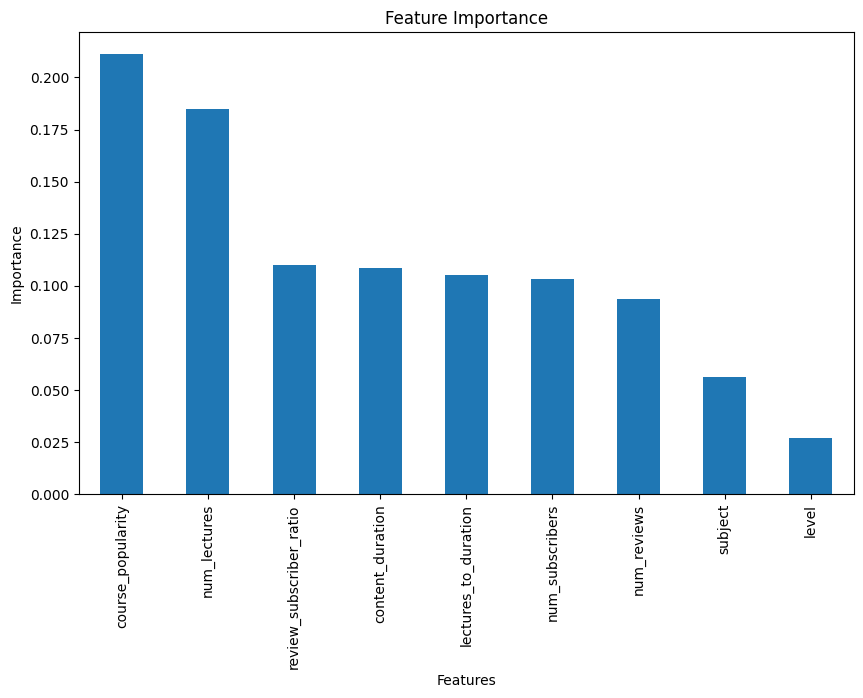

In [29]:
# Feature Importance
def plot_feature_importance(model, X):
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    feature_importances = feature_importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    feature_importances.plot(kind='bar')
    plt.title("Feature Importance")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()

# Step 9: Plot Feature Importance
plot_feature_importance(tuned_rf_model, X)